In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import anndata
import scanpy as sc
from sklearn

In [20]:
gene_mean = pd.read_msgpack('../ITSpatialPairwiseDEG/ClusterMean.genes.msg').T
group_order = [
    'IT-L23+ORB', 'IT-L5+ORB', 'IT-L23+PFC', 'IT-L5+PFC', 'IT-L6+PFC',
    'IT-L23+ACA', 'IT-L5+ACA', 'IT-L6+ACA', 'IT-L23+AI', 'IT-L5+AI',
    'IT-L6+AI', 'IT-L23+MOs', 'IT-L4+MOs', 'IT-L5+MOs', 'IT-L6+MOs',
    'IT-L23+MOp', 'IT-L4+MOp', 'IT-L5+MOp', 'IT-L6+MOp', 'IT-L23+SSp',
    'IT-L4+SSp', 'IT-L5+SSp', 'IT-L6+SSp', 'IT-L23+SSs', 'IT-L4+SSs',
    'IT-L5+SSs', 'IT-L6+SSs'
]

gene_mean = gene_mean[group_order].copy()
gene_mean = gene_mean.loc[:, gene_mean.columns.str.startswith('IT-L23')]

# each sample is already normalized, then scale the gene
gene_mean = (gene_mean - gene_mean.mean(axis=1)[:, None]) / gene_mean.std(axis=1)[:, None]

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
# gene_mean.to_csv('TotalGene.csv')
gene_mean.shape

(50231, 8)

In [22]:
marker_genes = joblib.load('../region_hypo_genes.IT-L23.obj')
total_markers = set(sum([list(i) for i in marker_genes.values()], []))

marker_df = gene_mean.loc[total_markers]

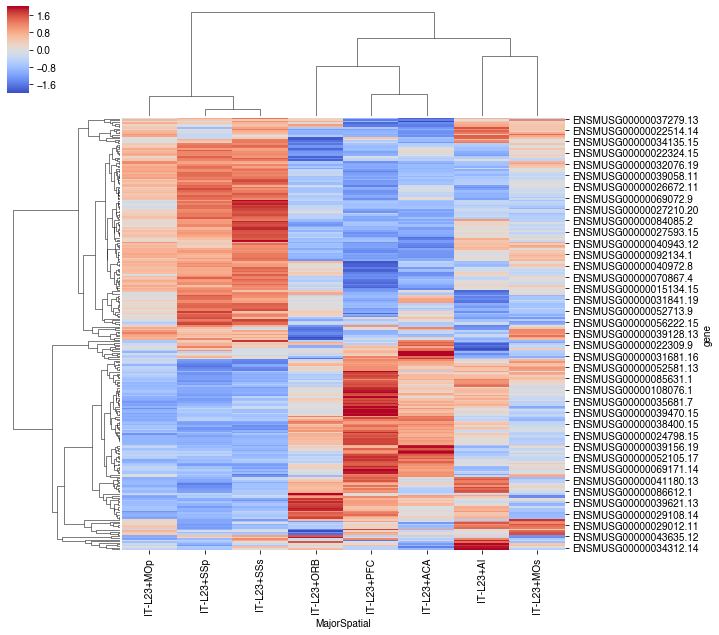

In [24]:
sns.clustermap(marker_df, cmap='coolwarm',
               col_cluster=True, vmin=-2, vmax=2, metric='correlation')

## Regress out layer

In [12]:
adata = anndata.AnnData(marker_df.values,
                        obs=pd.DataFrame([], index=marker_df.index),
                        var=pd.DataFrame([], index=marker_df.columns)).T
adata.obs['Layer'] = adata.obs_names.map(lambda i: i.split('+')[0])
adata

AnnData object with n_obs × n_vars = 27 × 4219 
    obs: 'Layer'

In [14]:
sc.pp.regress_out(adata, ['Layer'])
sc.pp.scale(adata)

... storing 'Layer' as categorical
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [15]:
new_marker_df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names).T

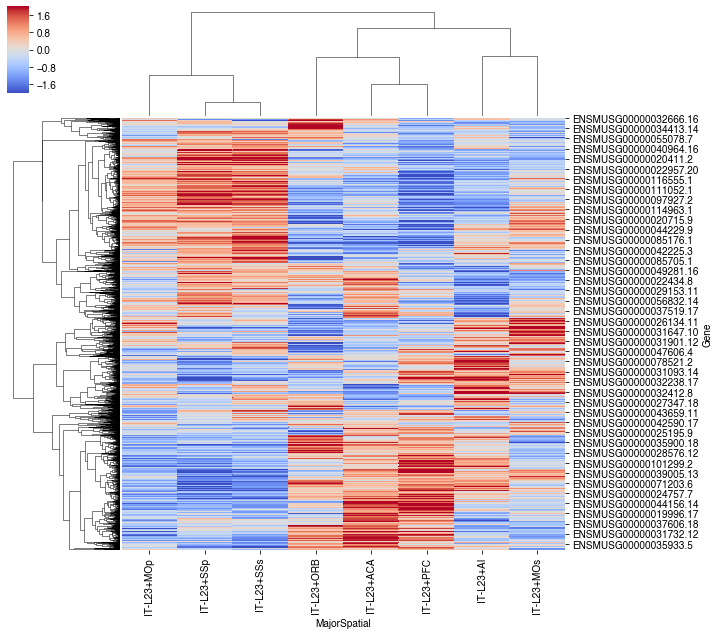

In [48]:
sns.clustermap(new_marker_df.loc[:, new_marker_df.columns.str.startswith('IT-L23')], cmap='coolwarm',
               col_cluster=True, vmin=-2, vmax=2, metric='correlation')

In [19]:
marker_df.to_csv('TotalPairwiseMarkerGene.csv')
marker_df.shape

(4219, 27)

In [20]:
new_marker_df.to_csv('TotalPairwiseMarkerGene.regress_out_layer.csv')
new_marker_df.shape

(4219, 27)

In [26]:
adata = adata.T

In [28]:
sc.pp.pca(adata, n_comps=27)

In [33]:
adata.obsm['X_pca'] = adata.X

In [40]:
sc.pp.neighbors(adata, n_neighbors = 15,
    n_pcs = 27, metric='correlation')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../miniconda3/envs/clustering/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


In [41]:
sc.tl.umap(adata)

In [42]:
sc.tl.leiden(adata)

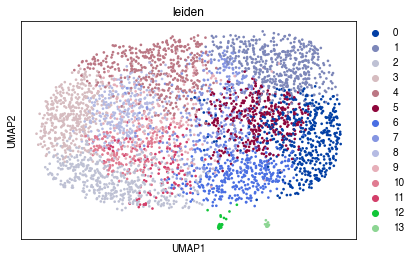

In [43]:
sc.pl.umap(adata, color='leiden')

In [44]:
adata.obs.to_csv('gene_cluster.leiden.csv')